1. Nama : Sri Kresna Maha Dewa
2. Asal Instansi : Politeknik Negeri Malang
3. Email : srikresna383@gmail.com

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"srikresna","key":"c90f9c19af6b129911ae9410dd23cde4"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d robikscube/hourly-energy-consumption

 79% 9.00M/11.4M [00:00<00:00, 38.8MB/s]
100% 11.4M/11.4M [00:00<00:00, 47.0MB/s]


In [5]:
!unzip hourly-energy-consumption.zip

Archive:  hourly-energy-consumption.zip
  inflating: AEP_hourly.csv          
  inflating: COMED_hourly.csv        
  inflating: DAYTON_hourly.csv       
  inflating: DEOK_hourly.csv         
  inflating: DOM_hourly.csv          
  inflating: DUQ_hourly.csv          
  inflating: EKPC_hourly.csv         
  inflating: FE_hourly.csv           
  inflating: NI_hourly.csv           
  inflating: PJME_hourly.csv         
  inflating: PJMW_hourly.csv         
  inflating: PJM_Load_hourly.csv     
  inflating: est_hourly.paruqet      
  inflating: pjm_hourly_est.csv      


In [1]:
import pandas as pd

df = pd.read_csv('EKPC_hourly.csv')
df

,Datetime,EKPC_MW
0,2013-12-31 01:00:00,1861.0
1,2013-12-31 02:00:00,1835.0
2,2013-12-31 03:00:00,1841.0
3,2013-12-31 04:00:00,1872.0
4,2013-12-31 05:00:00,1934.0
...,...,...
45329,2018-01-01 20:00:00,2866.0
45330,2018-01-01 21:00:00,2846.0
45331,2018-01-01 22:00:00,2883.0
45332,2018-01-01 23:00:00,2880.0


In [2]:
df.isnull().sum()

Datetime    0
EKPC_MW     0
dtype: int64

In [3]:
df['date']=pd.to_datetime(df['Datetime'])
df.head()

,Datetime,EKPC_MW,date
0,2013-12-31 01:00:00,1861.0,2013-12-31 01:00:00
1,2013-12-31 02:00:00,1835.0,2013-12-31 02:00:00
2,2013-12-31 03:00:00,1841.0,2013-12-31 03:00:00
3,2013-12-31 04:00:00,1872.0,2013-12-31 04:00:00
4,2013-12-31 05:00:00,1934.0,2013-12-31 05:00:00


In [4]:
df.dtypes

Datetime            object
EKPC_MW            float64
date        datetime64[ns]
dtype: object

In [5]:
new_df = df.drop('Datetime', axis = 1)
new_df.set_index('date', inplace = True)
new_df

,EKPC_MW
date,
2013-12-31 01:00:00,1861.0
2013-12-31 02:00:00,1835.0
2013-12-31 03:00:00,1841.0
2013-12-31 04:00:00,1872.0
2013-12-31 05:00:00,1934.0
...,...
2018-01-01 20:00:00,2866.0
2018-01-01 21:00:00,2846.0
2018-01-01 22:00:00,2883.0


In [6]:
new_df.dtypes

EKPC_MW    float64
dtype: object

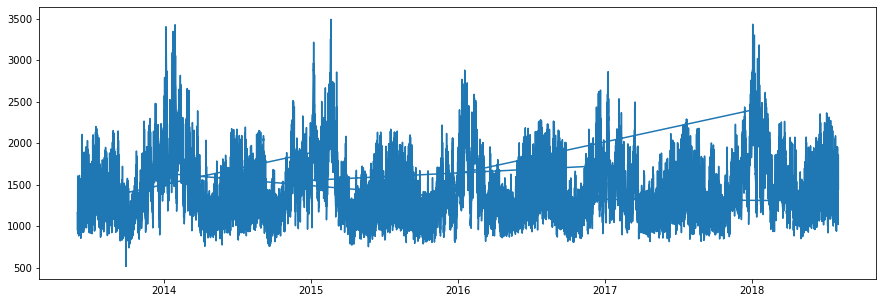

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 5))
plt.plot(new_df)
plt.show()



In [8]:
date = df['date'].values
energy = new_df['EKPC_MW'].values

print(date.shape)
print(energy.shape)

(45334,)
(45334,)


In [9]:
x = date.reshape(-1, 1)
y = energy.reshape(-1, 1)
print(x)
print(y)

[['2013-12-31T01:00:00.000000000']
 ['2013-12-31T02:00:00.000000000']
 ['2013-12-31T03:00:00.000000000']
 ...
 ['2018-01-01T22:00:00.000000000']
 ['2018-01-01T23:00:00.000000000']
 ['2018-01-02T00:00:00.000000000']]
[[1861.]
 [1835.]
 [1841.]
 ...
 [2883.]
 [2880.]
 [2846.]]


In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x, y)
date = scaler.transform(x)
energy = scaler.transform(y)

In [11]:
dt = date.flatten()
en = energy.flatten()

In [12]:
from sklearn.model_selection import train_test_split

date_train, date_test, energy_train, energy_test = train_test_split(dt, en, test_size = 0.2, shuffle = False)


In [13]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    
    return ds.batch(batch_size).prefetch(1)

In [19]:
print(len(energy_train), len(energy_test))

36267 9067


In [25]:
x_energy_train = windowed_dataset(energy_train, window_size=60, batch_size=100, shuffle_buffer=5000)
x_energy_test = windowed_dataset(energy_test, window_size=60, batch_size=100, shuffle_buffer=5000)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = "causal", activation="relu", input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences = True),
  tf.keras.layers.LSTM(64, return_sequences = True),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

In [26]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, #learning rate
                                    momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [27]:
threshold_mae = (new_df['EKPC_MW'].max() - new_df['EKPC_MW'].min()) * 10/100
print(threshold_mae)

297.6


In [28]:
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < threshold_mae) and (logs.get('val_mae') < threshold_mae):
      self.model.stop_training = True
      print("\nMAE < 10% dari skala data")
callbacks = myCallback()


#train
tf.keras.backend.set_floatx('float64')
history = model.fit(x_energy_train,
                    validation_data = x_energy_test,
                    epochs=100,
                    callbacks = [callbacks]
                    )

Epoch 1/100
    362/Unknown - 22s 48ms/step - loss: 34.4767 - mae: 34.9526
MAE < 10% dari skala data
363/363 [==============================] - 25s 57ms/step - loss: 34.4713 - mae: 34.9472 - val_loss: 6.4677 - val_mae: 6.9059
